In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "200X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 1


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_200X-BREAKHIS-Dataset-60-10-30-VGGINet/1'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/200X/1'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.


Found 181 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1657 - accuracy: 0.4922

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 3s - loss: 2.0072 - accuracy: 0.6484

3/9 [=========>....................] - ETA: 3s - loss: 2.5911 - accuracy: 0.6953

4/9 [============>.................] - ETA: 6s - loss: 2.7325 - accuracy: 0.7188

5/9 [===============>..............] - ETA: 5s - loss: 2.7336 - accuracy: 0.7266

6/9 [===================>..........] - ETA: 3s - loss: 2.7256 - accuracy: 0.7344

7/9 [======================>.......] - ETA: 2s - loss: 2.8012 - accuracy: 0.7455

8/9 [=========================>....] - ETA: 1s - loss: 2.8283 - accuracy: 0.7539

9/9 [==============================] - ETA: 0s - loss: 2.9181 - accuracy: 0.7553

9/9 [==============================] - 31s 3s/step - loss: 2.9181 - accuracy: 0.7553 - val_loss: 5.3609 - val_accuracy: 0.8840


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7248 - accuracy: 0.8438

2/9 [=====>........................] - ETA: 3s - loss: 1.8731 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 3s - loss: 3.1051 - accuracy: 0.8073

4/9 [============>.................] - ETA: 7s - loss: 3.2804 - accuracy: 0.7852

5/9 [===============>..............] - ETA: 5s - loss: 2.9603 - accuracy: 0.7984

6/9 [===================>..........] - ETA: 4s - loss: 2.6701 - accuracy: 0.8151

7/9 [======================>.......] - ETA: 2s - loss: 2.5340 - accuracy: 0.8281

8/9 [=========================>....] - ETA: 1s - loss: 2.7086 - accuracy: 0.8320

9/9 [==============================] - ETA: 0s - loss: 2.6661 - accuracy: 0.8353

9/9 [==============================] - 14s 2s/step - loss: 2.6661 - accuracy: 0.8353 - val_loss: 14.0624 - val_accuracy: 0.7956


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 3.9177 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 14s - loss: 2.7840 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 15s - loss: 2.4983 - accuracy: 0.8828

4/9 [============>.................] - ETA: 11s - loss: 2.0792 - accuracy: 0.8965

5/9 [===============>..............] - ETA: 7s - loss: 1.9885 - accuracy: 0.8922 

6/9 [===================>..........] - ETA: 5s - loss: 1.9205 - accuracy: 0.8867

7/9 [======================>.......] - ETA: 3s - loss: 1.8931 - accuracy: 0.8828

8/9 [=========================>....] - ETA: 1s - loss: 1.8255 - accuracy: 0.8828

9/9 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.8832

9/9 [==============================] - 16s 2s/step - loss: 1.8124 - accuracy: 0.8832 - val_loss: 2.9963 - val_accuracy: 0.9006


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9959 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.6513 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 0.6991 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 9s - loss: 0.7494 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 7s - loss: 0.8336 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 4s - loss: 0.7807 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 0.7995 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 0.7884 - accuracy: 0.9209

9/9 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.9218

9/9 [==============================] - 16s 2s/step - loss: 0.8496 - accuracy: 0.9218 - val_loss: 7.5229 - val_accuracy: 0.8122


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9314 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 11s - loss: 1.3145 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 8s - loss: 1.2423 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 1.3127 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 7s - loss: 1.3295 - accuracy: 0.9094

6/9 [===================>..........] - ETA: 4s - loss: 1.2659 - accuracy: 0.9089

7/9 [======================>.......] - ETA: 3s - loss: 1.2942 - accuracy: 0.9062

8/9 [=========================>....] - ETA: 1s - loss: 1.2059 - accuracy: 0.9062

9/9 [==============================] - ETA: 0s - loss: 1.1817 - accuracy: 0.9089

9/9 [==============================] - 15s 2s/step - loss: 1.1817 - accuracy: 0.9089 - val_loss: 1.2765 - val_accuracy: 0.9337


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1758 - accuracy: 0.8438

2/9 [=====>........................] - ETA: 13s - loss: 1.0116 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 9s - loss: 1.1188 - accuracy: 0.8880 

4/9 [============>.................] - ETA: 9s - loss: 1.0206 - accuracy: 0.8984

5/9 [===============>..............] - ETA: 7s - loss: 0.9732 - accuracy: 0.9000

6/9 [===================>..........] - ETA: 4s - loss: 0.9178 - accuracy: 0.9023

7/9 [======================>.......] - ETA: 3s - loss: 0.9407 - accuracy: 0.9029

8/9 [=========================>....] - ETA: 1s - loss: 0.8885 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.9089

9/9 [==============================] - 15s 2s/step - loss: 0.8903 - accuracy: 0.9089 - val_loss: 1.0575 - val_accuracy: 0.9392


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0000 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.8258 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 10s - loss: 0.7485 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.8022 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 0.8129 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.7464 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.7945 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.9209

9/9 [==============================] - 16s 2s/step - loss: 0.8192 - accuracy: 0.9209 - val_loss: 0.6571 - val_accuracy: 0.9061


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4285 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6455 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.5838 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 9s - loss: 0.6392 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.6277 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 5s - loss: 0.6744 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.7001 - accuracy: 0.9252

8/9 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.9189

9/9 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.9154

9/9 [==============================] - 16s 2s/step - loss: 0.7000 - accuracy: 0.9154 - val_loss: 1.0086 - val_accuracy: 0.8895


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8758 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 0.6507 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 0.8002 - accuracy: 0.9062 

4/9 [============>.................] - ETA: 9s - loss: 0.8556 - accuracy: 0.9062

5/9 [===============>..............] - ETA: 7s - loss: 0.7178 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 5s - loss: 0.8118 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.8052 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 0.7955 - accuracy: 0.9209

9/9 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.9190

9/9 [==============================] - 16s 2s/step - loss: 0.7973 - accuracy: 0.9190 - val_loss: 0.8507 - val_accuracy: 0.9448


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4462 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.6543 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.6526 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.5432 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.5905 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 4s - loss: 0.6719 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.6704 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.7038 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.9264

9/9 [==============================] - 15s 2s/step - loss: 0.7396 - accuracy: 0.9264 - val_loss: 0.6093 - val_accuracy: 0.9282


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9599 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.7759 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.6786 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.7425 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7812 - accuracy: 0.9312

6/9 [===================>..........] - ETA: 4s - loss: 0.7310 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.8670 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.8193 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.9264

9/9 [==============================] - 15s 2s/step - loss: 0.8392 - accuracy: 0.9264 - val_loss: 0.5001 - val_accuracy: 0.9171


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5632 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4402 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.6259 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 9s - loss: 0.7587 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 0.8545 - accuracy: 0.9172

6/9 [===================>..........] - ETA: 5s - loss: 0.8499 - accuracy: 0.9193

7/9 [======================>.......] - ETA: 3s - loss: 0.8905 - accuracy: 0.9141

8/9 [=========================>....] - ETA: 1s - loss: 0.9352 - accuracy: 0.9141

9/9 [==============================] - ETA: 0s - loss: 0.9434 - accuracy: 0.9144

9/9 [==============================] - 16s 2s/step - loss: 0.9434 - accuracy: 0.9144 - val_loss: 0.8282 - val_accuracy: 0.9337


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1605 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.3104 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.5715 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.7411 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7179 - accuracy: 0.9344 

6/9 [===================>..........] - ETA: 5s - loss: 0.7942 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.7422 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.7805 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.9338

9/9 [==============================] - 16s 2s/step - loss: 0.8099 - accuracy: 0.9338 - val_loss: 0.7717 - val_accuracy: 0.9282


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2607 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5607 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.6518 - accuracy: 0.9349

4/9 [============>.................] - ETA: 10s - loss: 0.6530 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 8s - loss: 0.6860 - accuracy: 0.9375 

6/9 [===================>..........] - ETA: 5s - loss: 0.6962 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.7623 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.8007 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.9393

9/9 [==============================] - 17s 2s/step - loss: 0.8420 - accuracy: 0.9393 - val_loss: 1.4170 - val_accuracy: 0.9392


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8902 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.7123 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7331 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.7261 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.7313 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.6679 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.6448 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.6475 - accuracy: 0.9326

9/9 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.9338

9/9 [==============================] - 16s 2s/step - loss: 0.6454 - accuracy: 0.9338 - val_loss: 0.8709 - val_accuracy: 0.9503


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6099 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.4218 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.4613 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.5149 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.4918 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.5156 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6654 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.9476

9/9 [==============================] - 16s 2s/step - loss: 0.6502 - accuracy: 0.9476 - val_loss: 0.4412 - val_accuracy: 0.9448


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8733 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.6038 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.8350 - accuracy: 0.9245

4/9 [============>.................] - ETA: 9s - loss: 0.7945 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.7954 - accuracy: 0.9234

6/9 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.7070 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.7244 - accuracy: 0.9336

9/9 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.9347

9/9 [==============================] - 16s 2s/step - loss: 0.6897 - accuracy: 0.9347 - val_loss: 1.0105 - val_accuracy: 0.9282


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5045 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.3944 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.3603 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.3395 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.3726 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.3630 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.3655 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.3963 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.9586

9/9 [==============================] - 16s 2s/step - loss: 0.3990 - accuracy: 0.9586 - val_loss: 1.2043 - val_accuracy: 0.9337


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5637 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.4533 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.3584 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.5412 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 8s - loss: 0.5925 - accuracy: 0.9344 

6/9 [===================>..........] - ETA: 5s - loss: 0.6026 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.6487 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.9328

9/9 [==============================] - 16s 2s/step - loss: 0.6547 - accuracy: 0.9328 - val_loss: 0.7701 - val_accuracy: 0.9337


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0443 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2427 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.2981 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.3085 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.3458 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.3764 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.4994 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.4843 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.9512

9/9 [==============================] - 16s 2s/step - loss: 0.5016 - accuracy: 0.9512 - val_loss: 1.1237 - val_accuracy: 0.9282


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9073 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.7232 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.7383 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 9s - loss: 0.6386 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5491 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 5s - loss: 0.5566 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5356 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.5419 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.9503

9/9 [==============================] - 16s 2s/step - loss: 0.5812 - accuracy: 0.9503 - val_loss: 0.9589 - val_accuracy: 0.9227


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3328 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.4606 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 10s - loss: 0.4028 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.4530 - accuracy: 0.9438 

6/9 [===================>..........] - ETA: 5s - loss: 0.4511 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.4850 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.4728 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.9466

9/9 [==============================] - 16s 2s/step - loss: 0.5186 - accuracy: 0.9466 - val_loss: 1.5804 - val_accuracy: 0.9116


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1336 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.8329 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 8s - loss: 0.6490 - accuracy: 0.9479

4/9 [============>.................] - ETA: 6s - loss: 0.6023 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.6118 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 5s - loss: 0.6163 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6381 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.7373 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.9402

9/9 [==============================] - 16s 2s/step - loss: 0.7376 - accuracy: 0.9402 - val_loss: 0.7638 - val_accuracy: 0.9392


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5720 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 16s - loss: 0.7672 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 11s - loss: 0.8939 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.8668 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.8004 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.7576 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.7421 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.7123 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.9485

9/9 [==============================] - 16s 2s/step - loss: 0.7104 - accuracy: 0.9485 - val_loss: 0.9972 - val_accuracy: 0.9392


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0004 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 3s - loss: 0.6942 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 4s - loss: 0.5812 - accuracy: 0.9427

4/9 [============>.................] - ETA: 7s - loss: 0.6013 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.6164 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 5s - loss: 0.6148 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.5673 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.5727 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.9457

9/9 [==============================] - 16s 2s/step - loss: 0.5395 - accuracy: 0.9457 - val_loss: 2.1838 - val_accuracy: 0.9061


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7645 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5397 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4205 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 10s - loss: 0.5076 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5174 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.5367 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5112 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5327 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.9623

9/9 [==============================] - 16s 2s/step - loss: 0.5045 - accuracy: 0.9623 - val_loss: 1.1216 - val_accuracy: 0.9282


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6152 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5017 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.4779 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5040 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.4554 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 4s - loss: 0.4642 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.4297 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.3963 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.9549

9/9 [==============================] - 15s 2s/step - loss: 0.3905 - accuracy: 0.9549 - val_loss: 1.7741 - val_accuracy: 0.9227


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3681 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3016 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4279 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.5024 - accuracy: 0.9590 

5/9 [===============>..............] - ETA: 7s - loss: 0.4232 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.5281 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4954 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4666 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.9604

9/9 [==============================] - 16s 2s/step - loss: 0.4450 - accuracy: 0.9604 - val_loss: 0.9250 - val_accuracy: 0.9392


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7630 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.6825 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 8s - loss: 0.5953 - accuracy: 0.9479

4/9 [============>.................] - ETA: 10s - loss: 0.5775 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.4807 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.5076 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5437 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5168 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.9568

9/9 [==============================] - 16s 2s/step - loss: 0.4868 - accuracy: 0.9568 - val_loss: 1.5661 - val_accuracy: 0.9227


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3893 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4154 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 15s - loss: 0.5854 - accuracy: 0.9661

4/9 [============>.................] - ETA: 11s - loss: 0.6021 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.5946 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.5083 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.5225 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.6240 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.9623

9/9 [==============================] - 16s 2s/step - loss: 0.6040 - accuracy: 0.9623 - val_loss: 1.8797 - val_accuracy: 0.9171


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4264 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.7277 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6785 - accuracy: 0.9557

4/9 [============>.................] - ETA: 7s - loss: 0.5609 - accuracy: 0.9609 

5/9 [===============>..............] - ETA: 7s - loss: 0.5001 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4846 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4564 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4005 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.3929 - accuracy: 0.9687 - val_loss: 0.7546 - val_accuracy: 0.9669


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3301 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.5080 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.4679 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.4467 - accuracy: 0.9609 

5/9 [===============>..............] - ETA: 7s - loss: 0.3668 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.3262 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.2994 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.2876 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.9650

9/9 [==============================] - 15s 2s/step - loss: 0.2954 - accuracy: 0.9650 - val_loss: 1.0311 - val_accuracy: 0.9503


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6044 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.3813 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4407 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5245 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.4322 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.4201 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4455 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.4462 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.9558

9/9 [==============================] - 15s 2s/step - loss: 0.4602 - accuracy: 0.9558 - val_loss: 0.8355 - val_accuracy: 0.9337


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2412 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4207 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3794 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.3421 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.5240 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.5546 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5062 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5164 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.9641

9/9 [==============================] - 16s 2s/step - loss: 0.4888 - accuracy: 0.9641 - val_loss: 0.7785 - val_accuracy: 0.9448


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1269 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3356 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.3740 - accuracy: 0.9531

4/9 [============>.................] - ETA: 9s - loss: 0.3017 - accuracy: 0.9570 

5/9 [===============>..............] - ETA: 7s - loss: 0.3428 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.3890 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4104 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.4245 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.9595

9/9 [==============================] - 16s 2s/step - loss: 0.4105 - accuracy: 0.9595 - val_loss: 1.2699 - val_accuracy: 0.9558


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8959 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.6403 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.5439 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 10s - loss: 0.5901 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5487 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4790 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5424 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.5216 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.9669

9/9 [==============================] - 16s 2s/step - loss: 0.5361 - accuracy: 0.9669 - val_loss: 1.7447 - val_accuracy: 0.9227


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0160 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.6550 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.6564 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.5102 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.4855 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 4s - loss: 0.4689 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4706 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4748 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.9632

9/9 [==============================] - 15s 2s/step - loss: 0.4478 - accuracy: 0.9632 - val_loss: 1.3942 - val_accuracy: 0.9282


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 3.3495e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0725 - accuracy: 0.9844    

3/9 [=========>....................] - ETA: 10s - loss: 0.1163 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.2809 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3276 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.3122 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3132 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3245 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.9660

9/9 [==============================] - 16s 2s/step - loss: 0.3345 - accuracy: 0.9660 - val_loss: 1.2508 - val_accuracy: 0.9392


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1699 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.5671 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3795 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 10s - loss: 0.5121 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4153 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4735 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4649 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4679 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.4780 - accuracy: 0.9687 - val_loss: 0.7693 - val_accuracy: 0.9613


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2106 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4819 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3264 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2623 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3050 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3851 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4163 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3671 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.4121 - accuracy: 0.9687 - val_loss: 0.8998 - val_accuracy: 0.9448


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1431 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3034 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2731 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.2450 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3091 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2984 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3112 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3056 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3152 - accuracy: 0.9761 - val_loss: 1.6584 - val_accuracy: 0.9337


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3046 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3911 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.2609 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.2206 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2930 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3682 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4128 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3681 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.3678 - accuracy: 0.9706 - val_loss: 0.8357 - val_accuracy: 0.9337


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4459 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3344 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4707 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.4110 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3888 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.5013 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.5185 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4673 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.9669

9/9 [==============================] - 16s 2s/step - loss: 0.4546 - accuracy: 0.9669 - val_loss: 0.8337 - val_accuracy: 0.9558


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4446 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.2782 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3011 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2630 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3550 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3146 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3146 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3224 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.9724

9/9 [==============================] - 16s 2s/step - loss: 0.3240 - accuracy: 0.9724 - val_loss: 1.2620 - val_accuracy: 0.9503


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6257 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 11s - loss: 0.5627 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4592 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 9s - loss: 0.3954 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4874 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4712 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.5372 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5184 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.9604

9/9 [==============================] - 16s 2s/step - loss: 0.5026 - accuracy: 0.9604 - val_loss: 0.6621 - val_accuracy: 0.9558


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 4.0989e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.3263 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.3031 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.3701 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3408 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3108 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3829 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.9761

9/9 [==============================] - 17s 2s/step - loss: 0.3714 - accuracy: 0.9761 - val_loss: 0.6602 - val_accuracy: 0.9448


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5500 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5418 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4334 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4068 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4225 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.3523 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3207 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3392 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.3196 - accuracy: 0.9742 - val_loss: 0.7908 - val_accuracy: 0.9669


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0640 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1631 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.2682 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2716 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2444 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3468 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3637 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3521 - accuracy: 0.9761 - val_loss: 0.6561 - val_accuracy: 0.9724


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1179 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3051 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.5227 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.6343 - accuracy: 0.9570 

5/9 [===============>..............] - ETA: 7s - loss: 0.5768 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.5366 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5310 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.5095 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.9678

9/9 [==============================] - 15s 2s/step - loss: 0.4876 - accuracy: 0.9678 - val_loss: 0.9611 - val_accuracy: 0.9503


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2799 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3035 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2849 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3389 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2962 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3091 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2804 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3008 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.2866 - accuracy: 0.9798 - val_loss: 1.8255 - val_accuracy: 0.9448


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1357 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3431 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2609 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2322 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.1858 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.1934 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2767 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2422 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.2455 - accuracy: 0.9770 - val_loss: 2.2226 - val_accuracy: 0.9392


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3463 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.2511 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.2354 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.1888 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2065 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.1894 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2130 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2007 - accuracy: 0.9825 - val_loss: 2.2177 - val_accuracy: 0.9448


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1997 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1444 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2462 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2355 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2133 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2618 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2544 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3277 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3162 - accuracy: 0.9752 - val_loss: 1.3957 - val_accuracy: 0.9503


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0830 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0903 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2493 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2016 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2629 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2873 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2473 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2550 - accuracy: 0.9853 - val_loss: 0.6597 - val_accuracy: 0.9503


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2889 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.1448 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 7s - loss: 0.1285 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.1021 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 6s - loss: 0.2039 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.1702 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1926 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1770 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9844

9/9 [==============================] - 15s 2s/step - loss: 0.1933 - accuracy: 0.9844 - val_loss: 1.4480 - val_accuracy: 0.9558


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9705 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5111 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.5313 - accuracy: 0.9648 

5/9 [===============>..............] - ETA: 8s - loss: 0.4322 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3803 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3857 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3379 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.9788

9/9 [==============================] - 17s 2s/step - loss: 0.3183 - accuracy: 0.9788 - val_loss: 0.7578 - val_accuracy: 0.9779


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1833 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2293 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2691 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3159 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2874 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2428 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2081 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1987 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.1872 - accuracy: 0.9844 - val_loss: 0.8146 - val_accuracy: 0.9779


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.0322 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.2638 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2958 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2950 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2730 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2791 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2454 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9853

9/9 [==============================] - 17s 2s/step - loss: 0.2312 - accuracy: 0.9853 - val_loss: 0.8763 - val_accuracy: 0.9558


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0566 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2800 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1877 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1459 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1168 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1106 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1598 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1398 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1797 - accuracy: 0.9880 - val_loss: 0.8492 - val_accuracy: 0.9613


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0615 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0308 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.2131 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.1602 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2243 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1937 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2326 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2836 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2741 - accuracy: 0.9807 - val_loss: 0.9713 - val_accuracy: 0.9613


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2704 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.1689 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.1328 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.1028 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1127 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.1120 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1434 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1259 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9844

9/9 [==============================] - 15s 2s/step - loss: 0.1500 - accuracy: 0.9844 - val_loss: 1.7957 - val_accuracy: 0.9558


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0546 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.2036 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1951 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2477 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1998 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2440 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2206 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2908 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2819 - accuracy: 0.9825 - val_loss: 1.0177 - val_accuracy: 0.9613


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3578 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.1790 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2105 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2389 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1916 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1693 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2033 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2713 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2703 - accuracy: 0.9825 - val_loss: 1.0165 - val_accuracy: 0.9613


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1311 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0985 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1111 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1108 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1254 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1290 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.1486 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.1723 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.1821 - accuracy: 0.9779 - val_loss: 0.9567 - val_accuracy: 0.9724


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4768 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4435 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4892 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.5057 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 7s - loss: 0.5099 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.6186 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.5440 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4885 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.9696

9/9 [==============================] - 16s 2s/step - loss: 0.4792 - accuracy: 0.9696 - val_loss: 1.1030 - val_accuracy: 0.9503


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.4658 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3106 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.2630 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2341 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1985 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2027 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1900 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2000 - accuracy: 0.9853 - val_loss: 1.5207 - val_accuracy: 0.9613


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1140 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1271 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 15s - loss: 0.0953 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1597 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1695 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2087 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2344 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2052 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2932 - accuracy: 0.9788 - val_loss: 1.0984 - val_accuracy: 0.9669


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2381 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4778 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4349 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.3571 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.3086 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.2744 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2842 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2617 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.2617 - accuracy: 0.9798 - val_loss: 1.7775 - val_accuracy: 0.9392


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 11s - loss: 0.1350 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.1367 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3101 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 6s - loss: 0.2623 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.2295 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 2s - loss: 0.2865 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9779

9/9 [==============================] - 15s 2s/step - loss: 0.2497 - accuracy: 0.9779 - val_loss: 1.5950 - val_accuracy: 0.9669


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2368 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2821 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2337 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.1761 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2074 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3299 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3068 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2857 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2929 - accuracy: 0.9807 - val_loss: 1.3170 - val_accuracy: 0.9503


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.6193 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 0.6168 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.4781 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3925 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.4408 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.4465 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4364 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.9788

9/9 [==============================] - 15s 2s/step - loss: 0.4215 - accuracy: 0.9788 - val_loss: 1.3912 - val_accuracy: 0.9503


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3377 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.4690 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4112 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3241 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.4032 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.3367 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2897 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2708 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9834

9/9 [==============================] - 15s 2s/step - loss: 0.2993 - accuracy: 0.9834 - val_loss: 1.2816 - val_accuracy: 0.9613


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1545 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1836 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2043 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.1635 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.1552 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1913 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2020 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.2595 - accuracy: 0.9798 - val_loss: 0.8608 - val_accuracy: 0.9890


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1312 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.2489 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1910 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1528 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.2024 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2434 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2590 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2760 - accuracy: 0.9816 - val_loss: 1.2112 - val_accuracy: 0.9558


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1090 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3957 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2638 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2342 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2399 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2302 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2269 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2949 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3268 - accuracy: 0.9770 - val_loss: 0.7005 - val_accuracy: 0.9724


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4653 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.3837 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.6711 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.6020 - accuracy: 0.9668 

5/9 [===============>..............] - ETA: 7s - loss: 0.5187 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.5179 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4777 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4375 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4651 - accuracy: 0.9752 - val_loss: 1.0151 - val_accuracy: 0.9724


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4696 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4115 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3014 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2402 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3198 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3495 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3437 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3730 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.3994 - accuracy: 0.9779 - val_loss: 1.2565 - val_accuracy: 0.9558


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4399 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1923 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.3431 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.3697 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.5036 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.4415 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.4851 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.4917 - accuracy: 0.9844 - val_loss: 1.3923 - val_accuracy: 0.9613


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0720 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.2858 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.3778 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3488 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3179 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.3305 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2833 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2711 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2999 - accuracy: 0.9834 - val_loss: 0.9607 - val_accuracy: 0.9503


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2007 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.5142 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.4376 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3757 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3192 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3309 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.3781 - accuracy: 0.9788 - val_loss: 0.8568 - val_accuracy: 0.9558


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 2.8703e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1063 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.0790 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0593 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.0533 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1162 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1225 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2197 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9853

9/9 [==============================] - 17s 2s/step - loss: 0.2128 - accuracy: 0.9853 - val_loss: 2.4319 - val_accuracy: 0.9227


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1892 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.0947 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 16s - loss: 0.0949 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.2338 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.2946 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2944 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.2985 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2712 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2624 - accuracy: 0.9752 - val_loss: 1.4104 - val_accuracy: 0.9448


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1739 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2211 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1795 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1528 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1855 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2099 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2081 - accuracy: 0.9825 - val_loss: 1.2058 - val_accuracy: 0.9558


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4917 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.5503 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4366 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3298 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3886 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4198 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3598 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3285 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3107 - accuracy: 0.9770 - val_loss: 1.6300 - val_accuracy: 0.9448


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1247 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0945 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1391 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3341 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3885 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.3335 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.2921 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2680 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.2525 - accuracy: 0.9779 - val_loss: 1.4087 - val_accuracy: 0.9558


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0551 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0276 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.2485 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1908 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2324 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1939 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2436 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2423 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2304 - accuracy: 0.9844 - val_loss: 1.8442 - val_accuracy: 0.9558


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4284 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3392 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3745 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2818 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2588 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2535 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2225 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1949 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9890

9/9 [==============================] - 16s 2s/step - loss: 0.1839 - accuracy: 0.9890 - val_loss: 2.5028 - val_accuracy: 0.9337


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2375 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3371 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2765 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2374 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2065 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2461 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2830 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2666 - accuracy: 0.9834 - val_loss: 1.3134 - val_accuracy: 0.9724


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1010 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.5649 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 16s - loss: 0.4721 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.3624 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.3095 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2662 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2522 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2606 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2502 - accuracy: 0.9844 - val_loss: 1.1313 - val_accuracy: 0.9779


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3405 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.3645 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.6065 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.6159 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4951 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.5020 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.4303 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3766 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.3821 - accuracy: 0.9844 - val_loss: 1.2289 - val_accuracy: 0.9448


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2313 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2240 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2427 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2639 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2114 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2195 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2451 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2282 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2398 - accuracy: 0.9834 - val_loss: 1.2080 - val_accuracy: 0.9724


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1980 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1320 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0990 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 8s - loss: 0.2867 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2389 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2490 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2265 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.2854 - accuracy: 0.9871 - val_loss: 1.1051 - val_accuracy: 0.9613


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2863 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2735 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 17s - loss: 0.3334 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.2501 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2560 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2687 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3480 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3792 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.3573 - accuracy: 0.9752 - val_loss: 1.1907 - val_accuracy: 0.9558


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3621 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 12s - loss: 0.1811 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1967 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.2930 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2602 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2595 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2295 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2008 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9890

9/9 [==============================] - 15s 2s/step - loss: 0.1949 - accuracy: 0.9890 - val_loss: 1.7018 - val_accuracy: 0.9558


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1983 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 16s - loss: 0.3999 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.2999 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2666 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2502 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2429 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2125 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2126 - accuracy: 0.9834 - val_loss: 1.8268 - val_accuracy: 0.9558


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2603 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1778 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2783 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.4048 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3238 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2744 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2571 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2499 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2363 - accuracy: 0.9825 - val_loss: 2.6665 - val_accuracy: 0.9171


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7129 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3564 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3315 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3151 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3269 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3181 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3415 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2988 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2895 - accuracy: 0.9788 - val_loss: 2.1013 - val_accuracy: 0.9282


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 6.2114e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.1147 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.1932 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1704 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2266 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2203 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2236 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1956 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1844 - accuracy: 0.9880 - val_loss: 0.7324 - val_accuracy: 0.9779


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 5.6127e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0978 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.0734 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1318 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1107 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1450 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1567 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1476 - accuracy: 0.9880 - val_loss: 0.8021 - val_accuracy: 0.9779


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0592 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0299 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.1037 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1424 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 7s - loss: 0.1247 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.1073 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0920 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.0807 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.9926

9/9 [==============================] - 16s 2s/step - loss: 0.0848 - accuracy: 0.9926 - val_loss: 0.8290 - val_accuracy: 0.9779


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

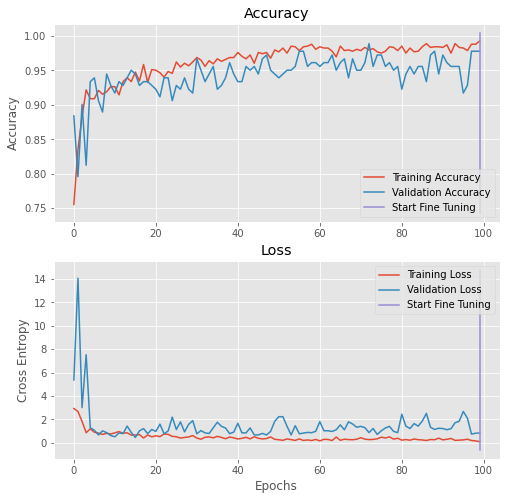

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.6735 - accuracy: 0.9141

2/5 [===========>..................] - ETA: 11s - loss: 2.7837 - accuracy: 0.9375

3/5 [=================>............] - ETA: 10s - loss: 1.9422 - accuracy: 0.9557

4/5 [=======================>......] - ETA: 5s - loss: 1.4567 - accuracy: 0.9668 

5/5 [==============================] - ETA: 0s - loss: 1.4429 - accuracy: 0.9670

5/5 [==============================] - 26s 5s/step - loss: 1.4429 - accuracy: 0.9670


[1.442928671836853, 0.9669724702835083]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

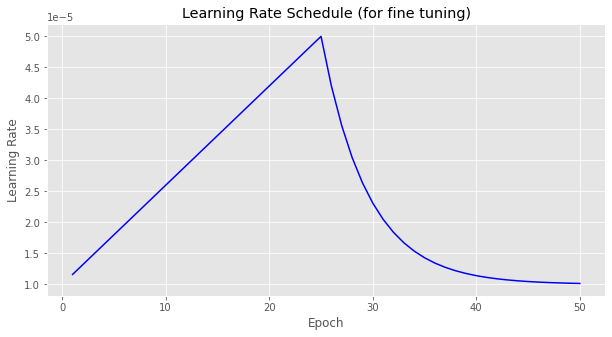

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1087 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.6037 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 4s - loss: 0.4025 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.4609 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.3729 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 11s - loss: 0.3647 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 12s - loss: 0.3310 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 11s - loss: 0.3278 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 9s - loss: 0.3506 - accuracy: 0.9774 

10/17 [================>.............] - ETA: 8s - loss: 0.3280 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 7s - loss: 0.2992 - accuracy: 0.9801

12/17 [====================>.........] - ETA: 5s - loss: 0.3186 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 4s - loss: 0.3135 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 3s - loss: 0.2912 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.2717 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2565 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9825

17/17 [==============================] - 22s 1s/step - loss: 0.2685 - accuracy: 0.9825 - val_loss: 0.7997 - val_accuracy: 0.9834



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1962 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.2933 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.2509 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.2007 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.3916 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.3394 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.2970 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.3002 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.4236 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 10s - loss: 0.5159 - accuracy: 0.9787

12/17 [====================>.........] - ETA: 7s - loss: 0.4755 - accuracy: 0.9792 

13/17 [=====================>........] - ETA: 5s - loss: 0.4651 - accuracy: 0.9772

14/17 [=======================>......] - ETA: 4s - loss: 0.4819 - accuracy: 0.9777

15/17 [=========================>....] - ETA: 2s - loss: 0.4611 - accuracy: 0.9781

16/17 [===========================>..] - ETA: 1s - loss: 0.4322 - accuracy: 0.9795

17/17 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.9807

17/17 [==============================] - 24s 1s/step - loss: 0.4072 - accuracy: 0.9807 - val_loss: 0.7755 - val_accuracy: 0.9834



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4345 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.2173 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.1567 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.1176 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.0949 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1613 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1612 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.1433 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1274 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1146 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1045 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0957 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0922 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0856 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0818 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0921 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.0868 - accuracy: 0.9908 - val_loss: 0.7631 - val_accuracy: 0.9834



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 3.2596e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.1027 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.1182 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0887 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0712 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1132 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0971 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0849 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1311 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1180 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1073 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1053 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1323 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1499 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1897 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.1733 - accuracy: 0.9871 - val_loss: 0.7583 - val_accuracy: 0.9890



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2822 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.1937 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.2771 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 13s - loss: 0.2586 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 15s - loss: 0.2069 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 12s - loss: 0.1724 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.1788 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 12s - loss: 0.1564 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 10s - loss: 0.1636 - accuracy: 0.9809

10/17 [================>.............] - ETA: 9s - loss: 0.1478 - accuracy: 0.9828 

11/17 [==================>...........] - ETA: 7s - loss: 0.1344 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 6s - loss: 0.1444 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 4s - loss: 0.1543 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 3s - loss: 0.1433 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.1418 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9825

17/17 [==============================] - 23s 1s/step - loss: 0.1497 - accuracy: 0.9825 - val_loss: 0.7568 - val_accuracy: 0.9890



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1261 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.1749 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 16s - loss: 0.1524 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 15s - loss: 0.1893 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 15s - loss: 0.1578 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 14s - loss: 0.1870 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 13s - loss: 0.1636 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 14s - loss: 0.1842 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.1658 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2242 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2055 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2229 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.3399 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.3174 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.3291 - accuracy: 0.9805

17/17 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.9816

17/17 [==============================] - 24s 1s/step - loss: 0.3100 - accuracy: 0.9816 - val_loss: 0.7548 - val_accuracy: 0.9890



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0146 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1487 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 22s - loss: 0.1116 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 22s - loss: 0.1105 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1686 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.2365 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 10s - loss: 0.2195 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.2263 - accuracy: 0.9831 

13/17 [=====================>........] - ETA: 5s - loss: 0.2421 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.2705 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2642 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9825

17/17 [==============================] - 25s 1s/step - loss: 0.2697 - accuracy: 0.9825 - val_loss: 0.7628 - val_accuracy: 0.9945



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.1373 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.0915 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 10s - loss: 0.1524 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 10s - loss: 0.1219 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 10s - loss: 0.1016 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0762 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0814 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1519 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1406 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1289 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1195 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1110 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1100 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1031 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9890

17/17 [==============================] - 22s 1s/step - loss: 0.1332 - accuracy: 0.9890 - val_loss: 0.7693 - val_accuracy: 0.9945



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.2524 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 8s - loss: 0.2898 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.2174 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.2528 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.2724 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.2335 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.2214 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1774 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 6s - loss: 0.1478 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1384 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1604 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1507 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1446 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9890

17/17 [==============================] - 22s 1s/step - loss: 0.1368 - accuracy: 0.9890 - val_loss: 0.7593 - val_accuracy: 0.9945



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0860 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.0517 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.0345 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0272 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0220 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.0366 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0285 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0350 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0321 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0294 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0273 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0254 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0540 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9945

17/17 [==============================] - 24s 1s/step - loss: 0.0604 - accuracy: 0.9945 - val_loss: 0.7516 - val_accuracy: 0.9945



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 1.5593 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 18s - loss: 0.8579 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 21s - loss: 0.8078 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 16s - loss: 0.6540 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.5232 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.4749 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.4071 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3562 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.3216 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2894 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.3398 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.3182 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2981 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2807 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2772 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2788 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9844

17/17 [==============================] - 24s 1s/step - loss: 0.2807 - accuracy: 0.9844 - val_loss: 0.7517 - val_accuracy: 0.9945



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 2.7672e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.2735 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 15s - loss: 0.1824 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 19s - loss: 0.1368 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1094 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0967 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1628 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1764 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1588 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 8s - loss: 0.1483 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 7s - loss: 0.1360 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1370 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1272 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1396 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1974 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9844

17/17 [==============================] - 23s 1s/step - loss: 0.2433 - accuracy: 0.9844 - val_loss: 0.7512 - val_accuracy: 0.9945



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.2625 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 12s - loss: 0.1750 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1166 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.0972 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.0833 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.0729 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.0648 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0583 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0530 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0486 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1132 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1180 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1102 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1078 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1109 - accuracy: 0.9890 - val_loss: 0.7488 - val_accuracy: 0.9945



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 5.9605e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.2025 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.2461 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.3375 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.3109 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 15s - loss: 0.3070 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 17s - loss: 0.2631 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.2801 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 13s - loss: 0.2490 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2567 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2334 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2140 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2151 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1998 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1864 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1880 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.1886 - accuracy: 0.9871 - val_loss: 0.7517 - val_accuracy: 0.9945



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0327 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 15s - loss: 0.1072 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.0804 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 12s - loss: 0.0659 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.0549 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0471 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0487 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0591 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.0949 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0960 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.0886 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.0866 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1599 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1499 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.1478 - accuracy: 0.9853 - val_loss: 0.7524 - val_accuracy: 0.9945



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7205 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 6s - loss: 0.3970 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 9s - loss: 0.3415 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.2561 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.2108 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 12s - loss: 0.2083 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 10s - loss: 0.2061 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 11s - loss: 0.1803 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 10s - loss: 0.1603 - accuracy: 0.9878

10/17 [================>.............] - ETA: 8s - loss: 0.1514 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 7s - loss: 0.2211 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 6s - loss: 0.2030 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2310 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.2468 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2303 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9880

17/17 [==============================] - 22s 1s/step - loss: 0.2221 - accuracy: 0.9880 - val_loss: 0.7466 - val_accuracy: 0.9890



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 4.0582e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0055 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 18s - loss: 0.2885 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 14s - loss: 0.2371 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.1924 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 13s - loss: 0.2827 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 14s - loss: 0.2426 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.2125 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 10s - loss: 0.1889 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1992 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.1811 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.1896 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1960 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.1954 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.1824 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9816

17/17 [==============================] - 24s 1s/step - loss: 0.2161 - accuracy: 0.9816 - val_loss: 0.7482 - val_accuracy: 0.9945



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 13s - loss: 0.0584 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0438 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0374 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0312 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0372 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.0417 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0796 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1450 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1574 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1626 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1517 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1363 - accuracy: 0.9890 - val_loss: 0.7472 - val_accuracy: 0.9945



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 2.5665e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 30s - loss: 0.2125 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 25s - loss: 0.3842 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 19s - loss: 0.3366 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.2813 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 14s - loss: 0.2344 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.2009 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 16s - loss: 0.1882 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.1673 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1560 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1419 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1301 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 6s - loss: 0.1214 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1135 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1110 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1352 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9862

17/17 [==============================] - 25s 1s/step - loss: 0.1543 - accuracy: 0.9862 - val_loss: 0.7470 - val_accuracy: 0.9945



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.1455 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 18s - loss: 0.0970 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1049 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0918 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0816 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0748 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1235 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1295 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1509 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1652 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1542 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1388 - accuracy: 0.9908 - val_loss: 0.7509 - val_accuracy: 0.9945



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.8626e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 2.4775e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.1546 - accuracy: 0.9883    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1474 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1310 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1148 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1203 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1083 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0985 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1277 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1453 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1354 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1264 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.1435 - accuracy: 0.9908 - val_loss: 0.7455 - val_accuracy: 0.9945



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0750 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 14s - loss: 0.0524 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.1449 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1159 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.2497 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2829 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2809 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.2714 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2513 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2304 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2128 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2785 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2600 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2437 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.2381 - accuracy: 0.9853 - val_loss: 0.7467 - val_accuracy: 0.9945



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 15s - loss: 0.0094 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 23s - loss: 0.2100 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.2690 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.4305 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 13s - loss: 0.3690 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3290 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2924 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2632 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2692 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 8s - loss: 0.2468 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 6s - loss: 0.2516 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2570 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2403 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2283 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9880

17/17 [==============================] - 25s 1s/step - loss: 0.2310 - accuracy: 0.9880 - val_loss: 0.7391 - val_accuracy: 0.9890



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0080 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0056 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0042 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0034 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.0061 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0420 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0368 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0387 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0555 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0505 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0427 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0607 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0566 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0678 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.0899 - accuracy: 0.9917 - val_loss: 0.7414 - val_accuracy: 0.9890



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.2812 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 18s - loss: 0.1875 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.1406 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1114 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.0867 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0782 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.0881 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0808 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0746 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0764 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.1002 - accuracy: 0.9908 - val_loss: 0.7425 - val_accuracy: 0.9890



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0582 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0291 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 4s - loss: 0.0194 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 7s - loss: 0.0145 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 12s - loss: 0.0097 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 11s - loss: 0.0083 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 10s - loss: 0.0116 - accuracy: 0.9965

10/17 [================>.............] - ETA: 9s - loss: 0.0104 - accuracy: 0.9969 

11/17 [==================>...........] - ETA: 8s - loss: 0.0095 - accuracy: 0.9972

12/17 [====================>.........] - ETA: 6s - loss: 0.0169 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0427 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0396 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0378 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0576 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.0542 - accuracy: 0.9926 - val_loss: 0.7421 - val_accuracy: 0.9890



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5647 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.2823 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 12s - loss: 0.2729 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.2078 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.1663 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1683 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.2290 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.2122 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1998 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1798 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1635 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1744 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1710 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1588 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1482 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9917

17/17 [==============================] - 23s 1s/step - loss: 0.1309 - accuracy: 0.9917 - val_loss: 0.7501 - val_accuracy: 0.9945



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 2.0142 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 1.1611 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.7741 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.6305 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.5760 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.4803 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.4117 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.3602 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.3202 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.3376 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.3340 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.3062 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.3016 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2800 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2733 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2562 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.2763 - accuracy: 0.9880 - val_loss: 0.7518 - val_accuracy: 0.9945



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3971 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2663 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.1776 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1825 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1597 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1419 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1383 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1459 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1338 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1250 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1161 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1193 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1119 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.1054 - accuracy: 0.9917 - val_loss: 0.7563 - val_accuracy: 0.9945



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1176e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 1.2926e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 8.6172e-07 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 6.6585e-07 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 18s - loss: 0.0676 - accuracy: 0.9937    

 6/17 [=========>....................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1512 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1278 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1150 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1106 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1021 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0948 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0969 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1002 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.0944 - accuracy: 0.9908 - val_loss: 0.7583 - val_accuracy: 0.9945



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 13s - loss: 0.3633 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 25s - loss: 0.2422 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2446 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.1957 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 18s - loss: 0.1758 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 15s - loss: 0.1507 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1196 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.3338 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.3062 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2807 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2658 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2985 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2930 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.2827 - accuracy: 0.9853 - val_loss: 0.7681 - val_accuracy: 0.9945



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0350 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0175 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 19s - loss: 0.0622 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1546 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1375 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1412 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1283 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1177 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1087 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1010 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0957 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0898 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.0989 - accuracy: 0.9899 - val_loss: 0.7793 - val_accuracy: 0.9945



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2747 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 4s - loss: 0.1374 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1791 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 14s - loss: 0.1433 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.1264 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.1356 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1205 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1085 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1175 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1112 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1033 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.0964 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.0957 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.0901 - accuracy: 0.9880 - val_loss: 0.7687 - val_accuracy: 0.9945



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0010 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.0130 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0097 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0078 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.1622 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.1595 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.2807 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.3268 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2942 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2676 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2453 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2264 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.2103 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1962 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1840 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1733 - accuracy: 0.9926 - val_loss: 0.7724 - val_accuracy: 0.9945



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 10s - loss: 4.7436e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 3.5584e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 12s - loss: 2.8468e-04 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 12s - loss: 2.3723e-04 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 15s - loss: 2.0334e-04 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 14s - loss: 1.7792e-04 - accuracy: 1.0000

 9/17 [==============>...............] - ETA: 13s - loss: 0.1692 - accuracy: 0.9965    

10/17 [================>.............] - ETA: 10s - loss: 0.1839 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.1929 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.2688 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.2729 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2886 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2693 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.3325 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.3649 - accuracy: 0.9880 - val_loss: 0.7747 - val_accuracy: 0.9945



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 2.1484e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.0573 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0382 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0287 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0229 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 17s - loss: 0.0395 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 15s - loss: 0.0351 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 14s - loss: 0.0325 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0292 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0266 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0244 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 4s - loss: 0.0209 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9969

16/17 [===========================>..] - ETA: 1s - loss: 0.0183 - accuracy: 0.9971

17/17 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9972

17/17 [==============================] - 24s 1s/step - loss: 0.0172 - accuracy: 0.9972 - val_loss: 0.7691 - val_accuracy: 0.9945



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0542 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 11s - loss: 0.1814 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1751 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.1506 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.1291 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.2020 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1795 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1913 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1751 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1605 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1482 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1376 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1284 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1385 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1308 - accuracy: 0.9899 - val_loss: 0.7602 - val_accuracy: 0.9945



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3659 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.3359 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.2904 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 19s - loss: 0.3138 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.2781 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 20s - loss: 0.2630 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 18s - loss: 0.2468 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 14s - loss: 0.2160 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 13s - loss: 0.1920 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.1728 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.1573 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.1497 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1557 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 3s - loss: 0.1446 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1647 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.1544 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9844

17/17 [==============================] - 23s 1s/step - loss: 0.1543 - accuracy: 0.9844 - val_loss: 0.7700 - val_accuracy: 0.9945



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 6.0323e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 4.0217e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 6.1622e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 15s - loss: 0.2013 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 16s - loss: 0.2785 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.2387 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.2088 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.3349 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.3166 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2878 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.2639 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.2647 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.2459 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.2405 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.2796 - accuracy: 0.9908 - val_loss: 0.7655 - val_accuracy: 0.9945



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 2.4959e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.3165 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 19s - loss: 0.2110 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 14s - loss: 0.2540 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.2032 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1694 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.1817 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1808 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1607 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1446 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1713 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1571 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.2515 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.2682 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2503 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2347 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.2349 - accuracy: 0.9890 - val_loss: 0.7717 - val_accuracy: 0.9945



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 1.0334 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.7311 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 16s - loss: 0.5414 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 20s - loss: 0.4060 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.3248 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 18s - loss: 0.2707 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.3455 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 15s - loss: 0.4632 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 14s - loss: 0.4117 - accuracy: 0.9792

10/17 [================>.............] - ETA: 11s - loss: 0.3705 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.3368 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.3237 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.3301 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.3104 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2911 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2729 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.2600 - accuracy: 0.9834 - val_loss: 0.7823 - val_accuracy: 0.9945



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0672 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0336 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 7s - loss: 0.0566 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0340 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 11s - loss: 0.0288 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.0764 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.1126 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1110 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1221 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.1209 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1108 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1545 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1434 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1339 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9917

17/17 [==============================] - 22s 1s/step - loss: 0.1182 - accuracy: 0.9917 - val_loss: 0.7858 - val_accuracy: 0.9945



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 6.5581e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 3.2791e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 2.1860e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 20s - loss: 0.1698 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1925 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1789 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1738 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2035 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.2095 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1886 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1715 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1572 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1453 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1363 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1284 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1210 - accuracy: 0.9908 - val_loss: 0.7823 - val_accuracy: 0.9945



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 3.3154e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.1066 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 4s - loss: 0.3098 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 6s - loss: 0.2550 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 7s - loss: 0.2040 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 10s - loss: 0.2149 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 8s - loss: 0.1842 - accuracy: 0.9888 

 8/17 [=============>................] - ETA: 9s - loss: 0.1612 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 9s - loss: 0.1433 - accuracy: 0.9913

10/17 [================>.............] - ETA: 8s - loss: 0.1290 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 7s - loss: 0.1172 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1075 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 4s - loss: 0.1106 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1028 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1655 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1746 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9899

17/17 [==============================] - 20s 1s/step - loss: 0.1644 - accuracy: 0.9899 - val_loss: 0.7786 - val_accuracy: 0.9945



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 7s - loss: 0.1349 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.1239 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.2284 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.1827 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.2390 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.2322 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 14s - loss: 0.2125 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.1889 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.1862 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1695 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1979 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1849 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1717 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1748 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1830 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.1724 - accuracy: 0.9853 - val_loss: 0.7872 - val_accuracy: 0.9945



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.1448 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.0965 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.0724 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.0483 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0414 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0976 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0867 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0781 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0710 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0681 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0628 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0718 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0656 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.0618 - accuracy: 0.9917 - val_loss: 0.7863 - val_accuracy: 0.9945



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.3403 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 23s - loss: 0.2438 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 21s - loss: 0.1828 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.1506 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.1255 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1076 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.0941 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.0921 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.0918 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1611 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1477 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1394 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1755 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1966 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1843 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1736 - accuracy: 0.9880 - val_loss: 0.7775 - val_accuracy: 0.9945



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 1.4975e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 4.2692e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 9s - loss: 6.2437e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 10s - loss: 4.6836e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 8s - loss: 3.7524e-04 - accuracy: 1.0000 

 6/17 [=========>....................] - ETA: 8s - loss: 3.1270e-04 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 8s - loss: 0.0168 - accuracy: 0.9978    

 8/17 [=============>................] - ETA: 9s - loss: 0.1203 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 9s - loss: 0.1069 - accuracy: 0.9965

10/17 [================>.............] - ETA: 8s - loss: 0.1093 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 7s - loss: 0.0994 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 6s - loss: 0.1098 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 4s - loss: 0.1014 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.0981 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0924 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0867 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9945

17/17 [==============================] - 20s 1s/step - loss: 0.0816 - accuracy: 0.9945 - val_loss: 0.7757 - val_accuracy: 0.9945



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 2.2352e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0823 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0411 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0337 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0282 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 17s - loss: 0.0241 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 16s - loss: 0.0214 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 14s - loss: 0.1829 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1646 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1796 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1668 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1723 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1600 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1657 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1554 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9880

17/17 [==============================] - 25s 1s/step - loss: 0.1801 - accuracy: 0.9880 - val_loss: 0.7847 - val_accuracy: 0.9945



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0666 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 13s - loss: 0.1522 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.2155 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.1724 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.1437 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1386 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1213 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1078 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0970 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1537 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1858 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1715 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1616 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1509 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1414 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1332 - accuracy: 0.9908 - val_loss: 0.7926 - val_accuracy: 0.9945


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

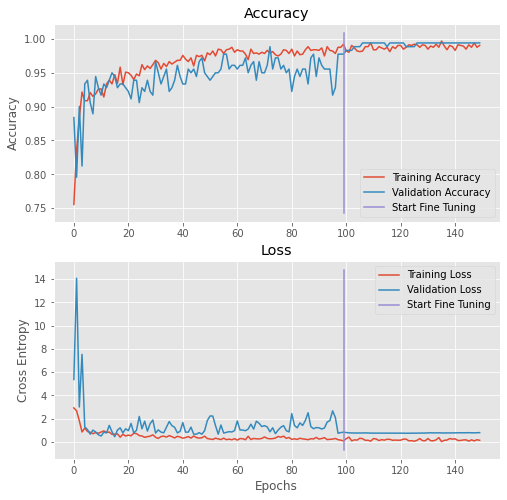

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.1344 - accuracy: 0.9375

2/5 [===========>..................] - ETA: 2s - loss: 2.2371 - accuracy: 0.9453

3/5 [=================>............] - ETA: 2s - loss: 1.6312 - accuracy: 0.9583

4/5 [=======================>......] - ETA: 1s - loss: 1.2234 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.9670

5/5 [==============================] - 6s 1s/step - loss: 1.2459 - accuracy: 0.9670


[1.2458738088607788, 0.9669724702835083]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9669724770642202
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       158
           1       0.97      0.98      0.98       387

    accuracy                           0.97       545
   macro avg       0.96      0.96      0.96       545
weighted avg       0.97      0.97      0.97       545



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

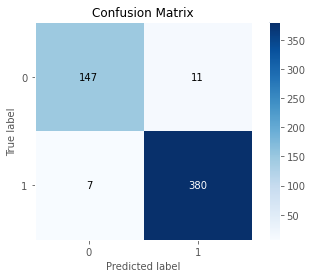

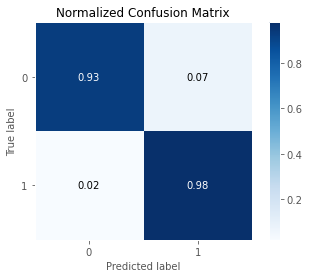

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

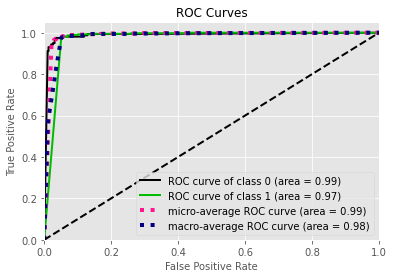

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       158
           1       0.97      0.98      0.98       387

    accuracy                           0.97       545
   macro avg       0.96      0.96      0.96       545
weighted avg       0.97      0.97      0.97       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.93      0.98      0.94      0.96      0.91       158
          1       0.97      0.98      0.93      0.98      0.96      0.92       387

avg / total       0.97      0.97      0.95      0.97      0.96      0.92       545

